# Preprocessing Step
---

This notebook carrieds out the preprocessing steps for the lipidomics data.

## Input

### Libraries

If it the first time running this notebook and the `Manifest.toml` is missing in the main directory or some packages are not installed, it is necessary to instantiate. It will create a `Manifest.toml` file, based on the`Project.toml` which contains all necessary package references to run the preprocessing pipeline. Then it will automatically download all the packages declared in that manifest and the project will be precompiled.  

In [1]:
isManifestexist = false # change to true to download and install all necessary packages

if isManifestexist 
    using Pkg
    Pkg.instantiate()
end

If RCall is used for the first time, one needs to indicate the location of the R home directory.

In [2]:
firstTimeRCall = false # change to true if it is the first time using RCall

if firstTimeRCall 
    ENV["R_HOME"] = "C:/PROGRA~1/R/R-41~1.2" # path obtained from R.home() in R
    using Pkg
    Pkg.build("RCall")
end     

Load libraries

In [3]:
using CSV, DataFrames, Missings, CategoricalArrays
using StatsBase, Statistics, MultivariateStats, GLM
using RCall
using FreqTables, Plots, StatsPlots

### Ext. Functions

In [4]:
include(joinpath(@__DIR__,"..","..","src","preprocessing.jl" ));
include(joinpath(@__DIR__,"..","..","src","utils.jl" ));

### Load data

In [5]:
negLipids = realpath(joinpath(@__DIR__,"..","..","data","data_primary","Elam_NEG_LIPIDS_all-variables.csv" ))
dfNegLipids = DataFrame(CSV.File(negLipids));

In [6]:
posLipids = realpath(joinpath(@__DIR__,"..","..","data","data_primary","Elam_POS_LIPIDS-all-variables.csv" ))
dfPosLipids = DataFrame(CSV.File(posLipids));

## Chain of preprocessing

Wrangle => Imputation => Normalization => Log2 Transformation => Batch Effect Correction

## Wrangle data
----

### Lipids reference dictionnary

* We create a reference dictionnary for the lipids names.

In [7]:
# isCossRef = true
# Generate data frames based on cross reference naming for positive and negative lipids
dfNegLipids, dfNegCrossRef = crossRefLipids(dfNegLipids, "negLip");
dfPosLipids, dfPosCrossRef = crossRefLipids(dfPosLipids, "posLip", startCol = 6);

# save cross reference
dfNegCrossRef |> CSV.write("../../data/data_processed/inl2b_NegLipids_Xref.csv");
dfPosCrossRef |> CSV.write("../../data/data_processed/inl2b_PosLipids_Xref.csv");

# merge neg and pos look up table
dfLipCrossRef = deepcopy(dfNegCrossRef);
append!(dfLipCrossRef, dfPosCrossRef)
dfLipCrossRef |> CSV.write("../../data/data_processed/inl2b_Lipids_Xref.csv");

* Display the first row of negative lipids data frame:

In [8]:
first(dfNegLipids)

Row,Sample,Batch,Statin,Fish oil,negLip1,negLip2,negLip3,negLip4,negLip5,negLip6,negLip7,negLip8,negLip9,negLip10,negLip11,negLip12,negLip13,negLip14,negLip15,negLip16,negLip17,negLip18,negLip19,negLip20,negLip21,negLip22,negLip23,negLip24,negLip25,negLip26,negLip27,negLip28,negLip29,negLip30,negLip31,negLip32,negLip33,negLip34,negLip35,negLip36,negLip37,negLip38,negLip39,negLip40,negLip41,negLip42,negLip43,negLip44,negLip45,negLip46,negLip47,negLip48,negLip49,negLip50,negLip51,negLip52,negLip53,negLip54,negLip55,negLip56,negLip57,negLip58,negLip59,negLip60,negLip61,negLip62,negLip63,negLip64,negLip65,negLip66,negLip67,negLip68,negLip69,negLip70,negLip71,negLip72,negLip73,negLip74,negLip75,negLip76,negLip77,negLip78,negLip79,negLip80,negLip81,negLip82,negLip83,negLip84,negLip85,negLip86,negLip87,negLip88,negLip89,negLip90,negLip91,negLip92,negLip93,negLip94,negLip95,negLip96,⋯
,String15,String3,String15,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,1[CN01],B1,Statin,Fish Oil,8.18029e5,1.26252e6,6.89162e5,1.06e7,6.74509e6,5.48635e6,6.63608e6,2.69867e6,1.79651e6,2.02735e6,1.68251e6,1.373e6,1.44285e6,1.93714e6,5.25307e5,8.16419e5,5.99005e6,2.27864e6,2.38e8,1.46e7,3.17302e6,5.77e7,5.16e7,1.02e8,3.64085e6,3.19e7,1.82637e6,7.0072e6,2.71e7,3.14222e6,1.42741e6,4.89999e6,5.01844e6,4.14787e6,4.48643e6,1.09e7,7.52018e5,8.4254e6,7.16049e5,3.61418e6,4.20337e6,1.36925e6,1.42e7,1.74e7,3.40323e6,5.05422e6,5.40698e6,1.91257e5,3.50162e6,1.50373e6,4.11305e6,1.7508e6,2.36e7,6.46142e6,3.71976e6,3.81e7,1.0e7,4.06438e6,1.08e7,1.03846e6,1.41258e6,1.72e7,1.51e7,1.12e7,6.22588e6,3.51e7,1.16e7,3.05982e6,3.27294e6,1.19535e6,5.83515e6,7.3227e6,3.54693e6,2.14248e6,4.70459e6,2.09994e6,1.06356e6,1.61e7,5.1781e6,4.82563e6,2.04945e6,1.44942e6,1.12432e6,8.64786e5,7.80196e5,7.02744e5,1.29406e6,1.67e7,4.12819e6,5.48679e6,5.57766e6,4.38737e6,3.20796e6,1.94772e6,1.88604e6,1.68761e6,⋯


* Display the first row of positive lipids data frame:

In [9]:
first(dfPosLipids)

Row,Sample,Batch,Group,Statin,Oil,posLip1,posLip2,posLip3,posLip4,posLip5,posLip6,posLip7,posLip8,posLip9,posLip10,posLip11,posLip12,posLip13,posLip14,posLip15,posLip16,posLip17,posLip18,posLip19,posLip20,posLip21,posLip22,posLip23,posLip24,posLip25,posLip26,posLip27,posLip28,posLip29,posLip30,posLip31,posLip32,posLip33,posLip34,posLip35,posLip36,posLip37,posLip38,posLip39,posLip40,posLip41,posLip42,posLip43,posLip44,posLip45,posLip46,posLip47,posLip48,posLip49,posLip50,posLip51,posLip52,posLip53,posLip54,posLip55,posLip56,posLip57,posLip58,posLip59,posLip60,posLip61,posLip62,posLip63,posLip64,posLip65,posLip66,posLip67,posLip68,posLip69,posLip70,posLip71,posLip72,posLip73,posLip74,posLip75,posLip76,posLip77,posLip78,posLip79,posLip80,posLip81,posLip82,posLip83,posLip84,posLip85,posLip86,posLip87,posLip88,posLip89,posLip90,posLip91,posLip92,posLip93,posLip94,posLip95,⋯
,String15,String3,String15,String15,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,⋯
1,1[CN01],B1,Baseline,Statin,Fish Oil,8508466,9775182,7950093,5216666,5447071,3285025,2055899,13715965,2831455,721939,11057277,8871150,2267311,3905399,285602,1656441,1836879,2508780,9673330,3404311,53455624,42849473,706279359,3043927822,120035803,3384710,87408805,620628020,77721711,63742323,1385808,498908,1104047,12882626,9355927,3336180,2845122,40160898,22578277,19026288,12442858,20050795,1010881,33383914,15580104,9776560,1622654348,77390211,11409968,3832126,290363321,321917846,190706661,1538985,2265032,168560801,16636364,3724661,8646015,28635666,1343289,11351946,9449041,22057726,851481,1205135,17424223,1192779,1234205,8946701,16152355,524449151,92348660,40528656,7818766,102398167,37114422,8421025880,5953090101,3674096122,2622482797,897396958,723397202,364728089,819331426,310021860,415027669,73865571,141345526,602898761,31936774,271034801,134799619,36051551,3177489010,⋯


### Create a Group variable: CN, CS, CSbaseline

* Create a categorical variable named `Group` that indicates if a patient belonged to the control group (CN), the symptomatic group not on statin (CSbaseline) or the rechallenge symptomatic group on statin (CS).

In [10]:
dfNegLipids = addGroupCat(copy(dfNegLipids), false);
dfPosLipids = addGroupCat(copy(dfPosLipids), false);

Check group population:

In [11]:
countmap(dfNegLipids.Group; alg = :dict)

Dict{String, Int64} with 3 entries:
  "CN"         => 54
  "CS"         => 44
  "CSbaseline" => 44

### Convert to categorical: Batch, Statin and Oil

In [12]:
dfNegLipids = catBGSF(dfNegLipids, false);
dfPosLipids = catBGSF(dfPosLipids, false);

### Check tables

In [13]:
freqtable(dfNegLipids, :Group, :Batch)

3×4 Named Matrix{Int64}
Group ╲ Batch │ B1  B2  B3  B4
──────────────┼───────────────
CN            │ 13  14  14  13
CS            │ 12  11  10  11
CSbaseline    │ 10  11  12  11

In [14]:
freqtable(dfNegLipids, :Group, :FishOil)

3×2 Named Matrix{Int64}
Group ╲ FishOil │  no  yes
────────────────┼─────────
CN              │  39   15
CS              │  26   18
CSbaseline      │  27   17

## Impute missing data  
---
HM (Half of the Minimum): This method replaces missing elements with half of the minimum of non-missing elements in the corresponding variable.

In [15]:
dfNegLipids = imputeHM(dfNegLipids, startCol = 6);
dfPosLipids = imputeHM(dfPosLipids, startCol = 6);

## Normalization
----

### Probabilistic Quotient Normalization

> 1. Perform an integral normalization (typically a constant
integral of 100 is used).
> 2. Choose/calculate the reference spectrum (the best approach
is the calculation of the median spectrum of control samples).
> 3. Calculate the quotients of all variables of interest of the test
spectrum with those of the reference spectrum.
> 4. Calculate the median of these quotients.
> 5. Divide all variables of the test spectrum by this median.


In [16]:
dfNegLipids = pqnorm(dfNegLipids, startCol = 6);
dfPosLipids = pqnorm(dfPosLipids, startCol = 6);

## Transformation
---

A simple and widely used transformation to make data more symmetric and homoscedastic is the log-transformation.

In [17]:
dfNegLipids = log2tx(dfNegLipids, startCol = 6);
dfPosLipids = log2tx(dfPosLipids, startCol = 6);

In [18]:
first(dfPosLipids)

Row,Sample,Batch,Group,Statin,FishOil,posLip1,posLip2,posLip3,posLip4,posLip5,posLip6,posLip7,posLip8,posLip9,posLip10,posLip11,posLip12,posLip13,posLip14,posLip15,posLip16,posLip17,posLip18,posLip19,posLip20,posLip21,posLip22,posLip23,posLip24,posLip25,posLip26,posLip27,posLip28,posLip29,posLip30,posLip31,posLip32,posLip33,posLip34,posLip35,posLip36,posLip37,posLip38,posLip39,posLip40,posLip41,posLip42,posLip43,posLip44,posLip45,posLip46,posLip47,posLip48,posLip49,posLip50,posLip51,posLip52,posLip53,posLip54,posLip55,posLip56,posLip57,posLip58,posLip59,posLip60,posLip61,posLip62,posLip63,posLip64,posLip65,posLip66,posLip67,posLip68,posLip69,posLip70,posLip71,posLip72,posLip73,posLip74,posLip75,posLip76,posLip77,posLip78,posLip79,posLip80,posLip81,posLip82,posLip83,posLip84,posLip85,posLip86,posLip87,posLip88,posLip89,posLip90,posLip91,posLip92,posLip93,posLip94,posLip95,⋯
,String15,String3,String,String15,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,1[CN01],B1,CN,yes,yes,-7.35098,-7.15076,-7.44891,-8.05675,-7.9944,-8.72398,-9.40011,-6.6621,-8.93834,-10.9099,-6.97296,-7.29076,-9.2589,-8.47441,-12.2478,-9.7118,-9.56263,-9.1129,-7.16587,-8.67252,-4.69961,-5.01868,-0.975787,1.13184,-3.53256,-8.68085,-3.99018,-1.1623,-4.15964,-4.4457,-9.96915,-11.443,-10.2971,-6.75253,-7.214,-8.70168,-8.93139,-5.11216,-5.94302,-6.18996,-6.80264,-6.11429,-10.4243,-5.3788,-6.47825,-7.15056,0.224258,-4.1658,-6.92766,-8.50174,-2.25817,-2.10933,-2.86467,-9.8179,-9.26035,-3.04276,-6.38361,-8.54277,-7.32785,-5.60014,-10.0141,-6.93501,-7.19971,-5.97667,-10.6718,-10.1707,-6.31686,-10.1856,-10.1363,-7.27853,-6.42621,-1.40522,-3.91086,-5.09901,-7.47294,-3.76184,-5.22597,2.5999,2.09954,1.40329,0.916836,-0.630279,-0.941238,-1.9292,-0.761579,-2.16366,-1.74282,-4.23305,-3.2968,-1.20411,-5.44274,-2.35755,-3.36521,-5.26789,1.19379,⋯


## Adjusting for batch effects
---

### Check for batch effects

In [19]:
R"""
suppressMessages(library(mixOmics))
# suppressMessages(library(tidyverse));
"""

RObject{StrSxp}
 [1] "mixOmics"  "ggplot2"   "lattice"   "MASS"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     


In [20]:
dfNeg = catBGSF(dfNegLipids);
dfPos = catBGSF(dfPosLipids);

In [21]:
@rput dfNeg;
@rput dfPos;

In [22]:
R"summary(dfNeg[,c(1:5)])"

RObject{StrSxp}
    Sample          Batch          Group    Statin   FishOil 
 Length:142         B1:35   CN        :54   no :44   no :92  
 Class :character   B2:36   CS        :44   yes:98   yes:50  
 Mode  :character   B3:36   CSbaseline:44                    
                    B4:35                                    


In [23]:
# get matrix data
Xneg= copy(transpose(Matrix(dfNeg[:,6:end])));
Xpos= copy(transpose(Matrix(dfPos[:,6:end])));

# train a PCA model
Mneg = fit(PCA, Xneg; maxoutdim=10)
Mpos = fit(PCA, Xpos; maxoutdim=10);
Mpos;

In [24]:
size(Xneg)

(422, 142)

In [25]:
# get explained variance
explainedVarPCAneg = principalvars(Mneg)./tvar(Mneg)
explainedVarPCApos = principalvars(Mpos)./tvar(Mpos);

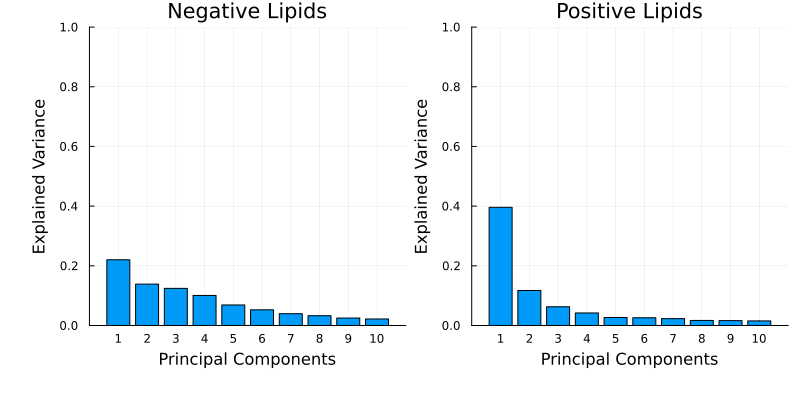

In [26]:
ticklabel = string.(collect(1:10))
pNegPCA =bar(
    explainedVarPCAneg, 
    orientation=:v, 
    xticks=(1:10, ticklabel),
    yflip=false, 
    legend = false, 
    title = "Negative Lipids",
    ylims = (0, 1),
    left_margin = (10,:mm),
    bottom_margin = (10,:mm)
)
xlabel!("Principal Components")
ylabel!("Explained Variance");

pPosPCA =bar(explainedVarPCApos, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Positive Lipids",ylims = (0, 1))
xlabel!("Principal Components")
ylabel!("Explained Variance");

plot(pNegPCA, pPosPCA, size = (800, 400))

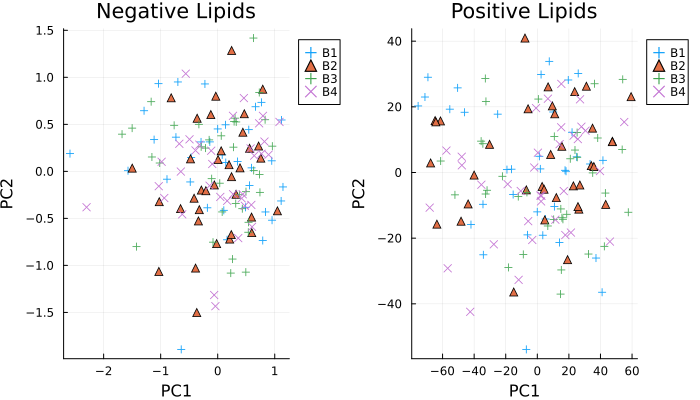

In [27]:
# get batch group labels
XbatchNeg = Vector(dfNeg[:,2]);
XbatchPos = Vector(dfPos[:,2]);

# apply PCA model 
Yneg = MultivariateStats.transform(Mneg, Xneg)
Ypos = MultivariateStats.transform(Mpos, Xpos)

# group results by testing set labels for color coding
B1neg = Yneg[:,XbatchNeg.=="B1"]; B1pos = Ypos[:,XbatchPos.=="B1"] 
B2neg = Yneg[:,XbatchNeg.=="B2"]; B2pos = Ypos[:,XbatchPos.=="B2"]
B3neg = Yneg[:,XbatchNeg.=="B3"]; B3pos = Ypos[:,XbatchPos.=="B3"]
B4neg = Yneg[:,XbatchNeg.=="B4"]; B4pos = Ypos[:,XbatchPos.=="B4"];

# visualize first 2 principal components
pNegScat = scatter(B1neg[1,:],B1neg[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2neg[1,:],B2neg[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3neg[1,:],B3neg[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4neg[1,:],B4neg[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pNegScat,xlabel="PC1",ylabel="PC2");

pPosScat = scatter(B1pos[1,:],B1pos[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2pos[1,:],B2pos[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3pos[1,:],B3pos[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4pos[1,:],B4pos[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pPosScat,xlabel="PC1",ylabel="PC2");

plot(pNegScat, pPosScat, legend = :outertopright, title = ["Negative Lipids" "Positive Lipids"], size = (700, 400))

In [28]:
plotattr("size")

(width_px, height_px) of the whole Plot.

Aliases: (:sizes, :windowsize, :wsize).

Type: Tuple{Integer, Integer}.

`Plot` attribute, defaults to `(600, 400)`.


### Lipids most influenced by batches

In [29]:
# Get variance explained
dfVarExplNeg = getVarExpl(Xneg, XbatchNeg, names(dfNeg)[6:end]);
dfVarExplPos = getVarExpl(Xpos, XbatchPos, names(dfPos)[6:end]);

In [30]:
first(dfVarExplNeg, 5)

Row,Lipids,VarExpl
,String,Float64
1,negLip418,0.460344
2,negLip102,0.431592
3,negLip417,0.413356
4,negLip285,0.3631
5,negLip151,0.295113


In [31]:
first(dfVarExplPos, 5)

Row,Lipids,VarExpl
,String,Float64
1,posLip338,0.694463
2,posLip23,0.640753
3,posLip1476,0.621632
4,posLip509,0.615811
5,posLip21,0.602905


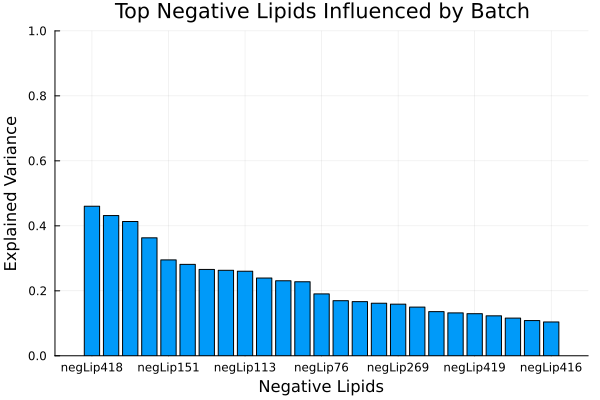

In [32]:
nTop = 25# sum(dfVarExpl.VarExpl>0.1)

ticklabel = dfVarExplNeg.Lipids[1:nTop]
pNeg =bar(dfVarExplNeg.VarExpl[1:nTop], orientation=:v, xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    yflip=false, legend = false, title = "Top Negative Lipids Influenced by Batch", ylims = (0, 1))
xlabel!("Negative Lipids")
ylabel!("Explained Variance")

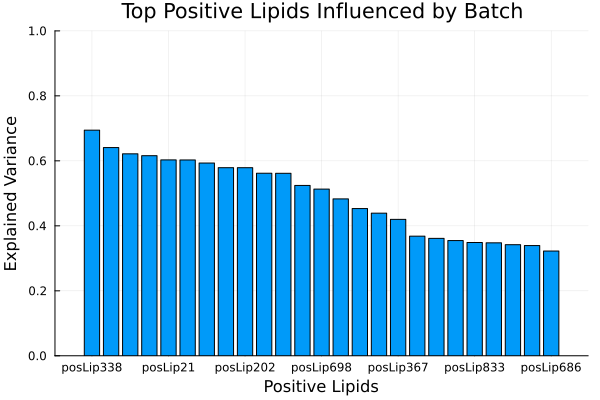

In [33]:
ticklabel = dfVarExplPos.Lipids[1:nTop]
pPos =bar(dfVarExplPos.VarExpl[1:nTop], orientation=:v, xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    yflip=false, legend = false, title = "Top Positive Lipids Influenced by Batch", ylims = (0, 1))
xlabel!("Positive Lipids")
ylabel!("Explained Variance")

### Most influential batch 

In [34]:
adjRsquaredPerLipidsPerBatch = getVarExplPerMetaPerBatch(Xneg, XbatchNeg, dfVarExplNeg.Lipids); 

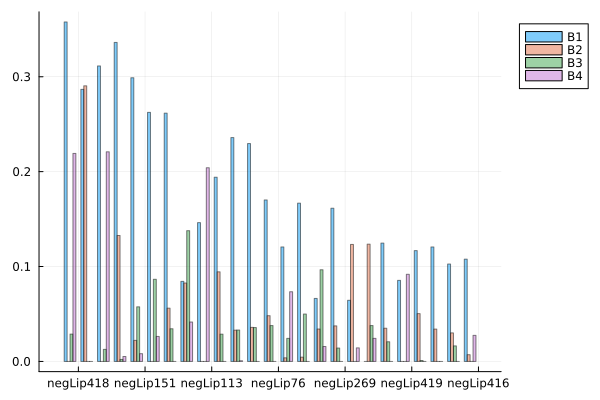

In [35]:
ticklabel = dfVarExplNeg.Lipids[1:nTop]
groupedbar(ticklabel, adjRsquaredPerLipidsPerBatch[1:nTop, :], 
    bar_position = :dodge, bar_width=0.7, alpha=0.5,
    xticks=(1:4:nTop, ticklabel[1:4:nTop]), 
    legend = :outertopright, label = ["B1" "B2" "B3" "B4"]
)

In [36]:
size(dfNeg)

(142, 427)

## Correct batch effect with combat 

In [37]:
R"""
suppressMessages(library(sva))
fCombat <- function(myDf){
mLipids <- as.matrix(myDf[,c(-1,-2,-3,-4,-5)])

modcombat <- model.matrix(~1, data = myDf[,c(2,3,5)])

combatLipids <- ComBat(dat=t(mLipids), batch = myDf$Batch, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)

# modGroupFishOil <- model.matrix(~Group*FishOil, data = myDf[,c(2,3,5)])
# combatFit = lm.fit(modGroupFishOil, t(combatLipids))

return(combatLipids)
}

mLipidsBatchAdjNeg <- t(fCombat(dfNeg));
mLipidsBatchAdjPos <- t(fCombat(dfPos));

"""
@rget mLipidsBatchAdjNeg;
@rget mLipidsBatchAdjPos;

┌ Warning: RCall.jl: Found4batches
│ Adjusting for0covariate(s) or covariate level(s)
│ Standardizing Data across genes
│ Fitting L/S model and finding priors
│ Finding parametric adjustments
│ Adjusting the Data
│ 
└ @ RCall /home/gregfa/.julia/packages/RCall/LWzAQ/src/io.jl:172
┌ Warning: RCall.jl: Found4batches
│ Adjusting for0covariate(s) or covariate level(s)
│ Standardizing Data across genes
│ Fitting L/S model and finding priors
│ Finding parametric adjustments
│ Adjusting the Data
│ 
└ @ RCall /home/gregfa/.julia/packages/RCall/LWzAQ/src/io.jl:172


In [38]:
# get matrix data
Xneg= copy(transpose(mLipidsBatchAdjNeg));
Xpos= copy(transpose(mLipidsBatchAdjPos));

# train a PCA model
Mneg = fit(PCA, Xneg; maxoutdim=10)
Mpos = fit(PCA, Xpos; maxoutdim=10);

In [39]:
size(Xneg)

(422, 142)

In [40]:
# get explained variance
explainedVarPCAneg = principalvars(Mneg)./tvar(Mneg)
explainedVarPCApos = principalvars(Mpos)./tvar(Mpos);

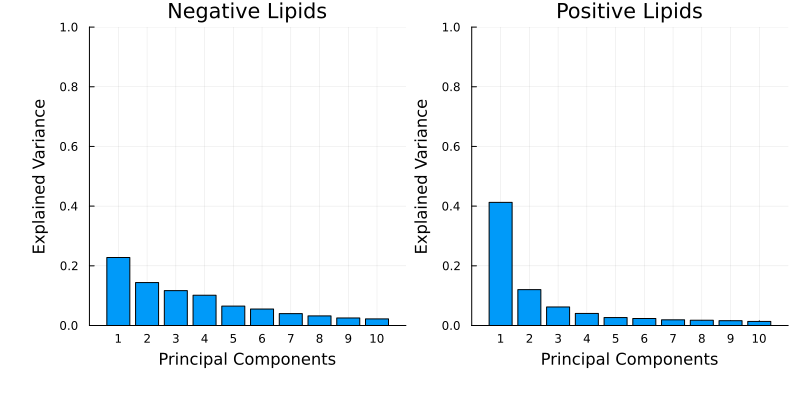

In [41]:
ticklabel = string.(collect(1:10))
pNegPCAAdj =bar(
    explainedVarPCAneg, 
    orientation=:v, 
    xticks=(1:10, ticklabel),
    yflip=false, 
    legend = false, 
    title = "Negative Lipids", 
    ylims = (0, 1),
    left_margin = (10,:mm),
    bottom_margin = (10,:mm)  
)
xlabel!("Principal Components")
ylabel!("Explained Variance");

pPosPCAAdj =bar(explainedVarPCApos, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Positive Lipids", ylims = (0, 1))
xlabel!("Principal Components")
ylabel!("Explained Variance");

plot(pNegPCAAdj, pPosPCAAdj, size = (800, 400))

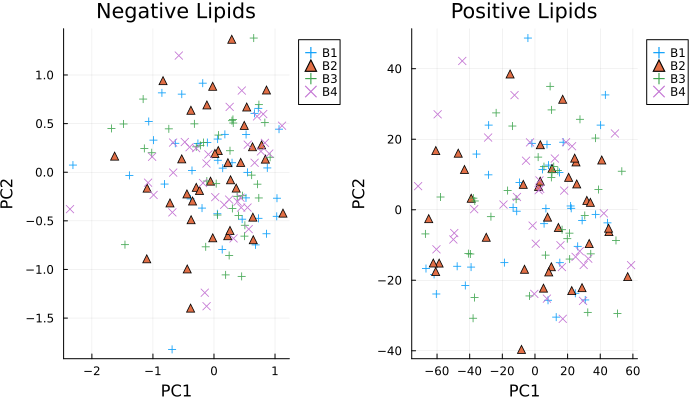

In [42]:
# get batch group labels
XbatchNeg = Vector(dfNeg[:,2]);
XbatchPos = Vector(dfPos[:,2]);

# apply PCA model 
Yneg = MultivariateStats.transform(Mneg, Xneg)
Ypos = MultivariateStats.transform(Mpos, Xpos)

# group results by testing set labels for color coding
B1neg = Yneg[:,XbatchNeg.=="B1"]; B1pos = Ypos[:,XbatchPos.=="B1"] 
B2neg = Yneg[:,XbatchNeg.=="B2"]; B2pos = Ypos[:,XbatchPos.=="B2"]
B3neg = Yneg[:,XbatchNeg.=="B3"]; B3pos = Ypos[:,XbatchPos.=="B3"]
B4neg = Yneg[:,XbatchNeg.=="B4"]; B4pos = Ypos[:,XbatchPos.=="B4"];

# visualize first 2 principal components
pNegScatAdj = scatter(B1neg[1,:],B1neg[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2neg[1,:],B2neg[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3neg[1,:],B3neg[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4neg[1,:],B4neg[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pNegScatAdj,xlabel="PC1",ylabel="PC2");

pPosScatAdj = scatter(B1pos[1,:],B1pos[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2pos[1,:],B2pos[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3pos[1,:],B3pos[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4pos[1,:],B4pos[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pPosScatAdj,xlabel="PC1",ylabel="PC2");

plot(pNegScatAdj, pPosScatAdj, legend = :outertopright, title = ["Negative Lipids" "Positive Lipids"], size = (700, 400))

### Lipids most influenced by batches after correction

In [43]:
# Get variance explained
dfVarExplNeg = getVarExpl(Xneg, XbatchNeg, names(dfNeg)[6:end]);
dfVarExplPos = getVarExpl(Xpos, XbatchPos, names(dfPos)[6:end]);

In [44]:
first(dfVarExplNeg, 5)

Row,Lipids,VarExpl
,String,Float64
1,negLip418,0.0775755
2,negLip417,0.0654405
3,negLip102,0.0608169
4,negLip113,0.0334086
5,negLip234,0.0311833


In [45]:
first(dfVarExplPos, 5)

Row,Lipids,VarExpl
,String,Float64
1,posLip1476,0.310483
2,posLip338,0.169601
3,posLip23,0.136144
4,posLip1312,0.114105
5,posLip21,0.112877


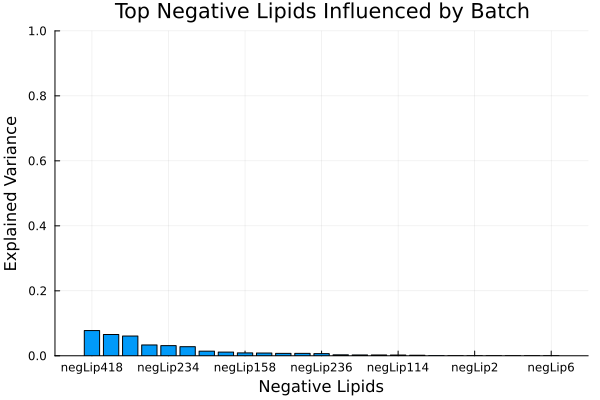

In [46]:
nTop = 25# sum(dfVarExpl.VarExpl>0.1)

ticklabel = dfVarExplNeg.Lipids[1:nTop]
pNegAdj =bar(dfVarExplNeg.VarExpl[1:nTop], orientation=:v, xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    yflip=false, legend = false, title = "Top Negative Lipids Influenced by Batch", ylims = (0, 1))
xlabel!("Negative Lipids")
ylabel!("Explained Variance")

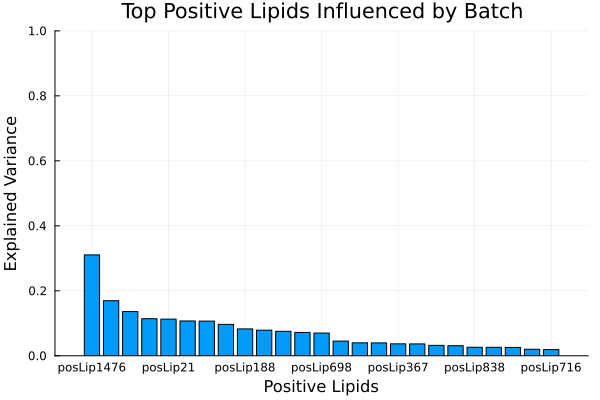

In [47]:
ticklabel = dfVarExplPos.Lipids[1:nTop]
pPosAdj =bar(dfVarExplPos.VarExpl[1:nTop], orientation=:v, xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    yflip=false, legend = false, title = "Top Positive Lipids Influenced by Batch", ylims = (0, 1))
xlabel!("Positive Lipids")
ylabel!("Explained Variance")

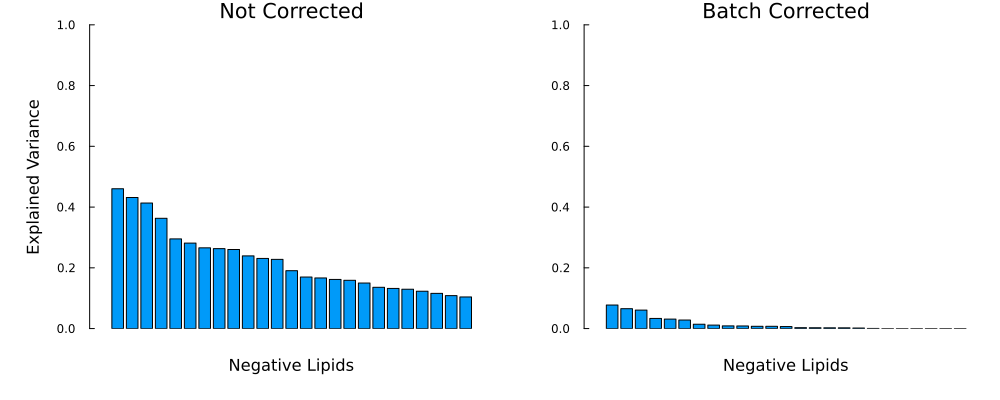

In [48]:
plot(pNeg, pNegAdj,
    legend = :false, 
    grid = false, 
    title = ["Not Corrected" "Batch Corrected"],
    ylabel = ["Explained Variance" ""],
    xaxis = false,
    left_margin = (10, :mm),
    bottom_margin = (10, :mm),
    size = (1000, 400)
)

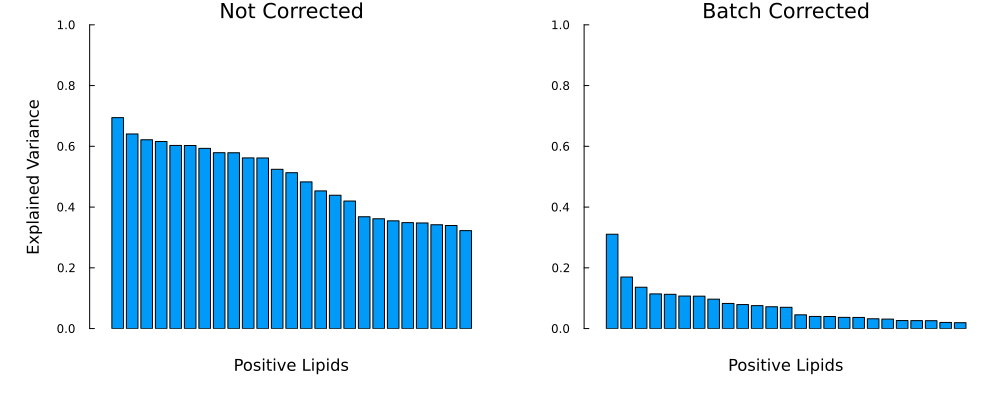

In [49]:
plot(pPos, pPosAdj,
    legend = :false, 
    grid = false, 
    title = ["Not Corrected" "Batch Corrected"],
    ylabel = ["Explained Variance" ""],
    xaxis = false,
    left_margin = (10, :mm),
    bottom_margin = (10, :mm),
    size = (1000, 400)
)

We use the F-test from `GLM.jl` to confirm with adjusted p-value that the batch effects has been corrected but the Combat methods. 

- Negative Lipids:

In [50]:
n = size(Xneg)[1]

adjPval = zeros(n)

for i in 1:n
    dftest = DataFrame(X = CategoricalArray(string.(XbatchNeg)), Y = Xneg[i,:])
    out = lm(@formula(Y ~ X), dftest);
    out0 = lm(@formula(Y ~ 1), dftest);
    my_ftest=ftest(out0.model, out.model)
    adjPval[i] = my_ftest.pval[2]
end

R"""
suppressMessages(library(stats))
suppressMessages(library(qvalue));
"""
@rput adjPval;

R"""
qobj <- qvalue(p = adjPval)
qVals <- qobj$qvalues;
"""
@rget qVals;

describe(qVals)

Summary Stats:
Length:         422
Missing Count:  0
Mean:           0.999770
Minimum:        0.999770
1st Quartile:   0.999770
Median:         0.999770
3rd Quartile:   0.999770
Maximum:        0.999770
Type:           Float64


- Positive Lipids

In [51]:
n = size(Xpos)[1]

adjPval = zeros(n)

for i in 1:n
    dftest = DataFrame(X = CategoricalArray(string.(XbatchPos)), Y = Xpos[i,:])
    out = lm(@formula(Y ~ X), dftest);
    out0 = lm(@formula(Y ~ 1), dftest);
    my_ftest=ftest(out0.model, out.model)
    adjPval[i] = my_ftest.pval[2]
end

R"""
suppressMessages(library(stats))
suppressMessages(library(qvalue));
"""
@rput adjPval;

R"""
qobj <- qvalue(p = adjPval)
qVals <- qobj$qvalues;
"""
@rget qVals;

describe(qVals)

Summary Stats:
Length:         1764
Missing Count:  0
Mean:           0.994301
Minimum:        0.000000
1st Quartile:   0.999970
Median:         0.999970
3rd Quartile:   0.999970
Maximum:        0.999970
Type:           Float64


## Save pretreatments

In [52]:
dfNegLipids[:, 6:end] = mLipidsBatchAdjNeg;
dfPosLipids[:, 6:end] = mLipidsBatchAdjPos;

In [53]:
dfNegLipids |> CSV.write("../../data/data_processed/inl2b_NegLipids.csv")

"../../data/data_processed/inl2b_NegLipids.csv"

In [54]:
dfPosLipids |> CSV.write("../../data/data_processed/inl2b_PosLipids.csv")

"../../data/data_processed/inl2b_PosLipids.csv"

In [55]:
# Join negative and positive lipids data frames
dfLipids = leftjoin(dfNegLipids, dfPosLipids[:, [1; collect(6:end)]], on = :Sample);

In [56]:
dfLipids |> CSV.write("../../data/data_processed/inl2b_Lipids.csv")

"../../data/data_processed/inl2b_Lipids.csv"

In [57]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 4 × Intel(R) Core(TM) i7-2640M CPU @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, sandybridge)
  Threads: 1 on 4 virtual cores
Environment:
  LD_GOLD = /home/gregfa/softwares/miniconda3/envs/r2d2/bin/x86_64-conda-linux-gnu-ld.gold


In [58]:
R"""
sessionInfo()
"""

RObject{VecSxp}
R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/gregfa/softwares/miniconda3/envs/r2d2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] qvalue_2.26.0       sva_3.42.0          BiocParallel_1.28.3
 [4] genefilter_1.76.0   mgcv_1.8-42         nlme_3.1-162       
 [7] mixOmics_6.18.1     ggplot2_3.4.2       lattice_0.21-8     
[10] MASS_7.3-60        

loaded via a namespace 